In [1]:
import numpy as np
import scipy
from scipy.optimize import minimize, LinearConstraint, Bounds
from scipy.linalg import lu, det
import matplotlib.pyplot as plt

# 1. Generate $Y$

$\vec{Y} = \Sigma^{1/2} \vec{v} $

where $ v_i \sim N(0, 1) $

In [2]:
# set parameters
p = 1000 # dimension
paramTrue = [1,.1] # True theta1, theta2

In [3]:
# function that makes covariance matrix
def Sigma(param, p):
    I = np.eye(p) #dtype=np.float32)
    O = np.ones([p,p]) #dtype=np.float32)
    return I*param[0]+(O-I)*param[1]

In [4]:
# check if SigmaTrue is positive semidefinite
SigmaTrue = Sigma(paramTrue, p)
np.linalg.eig(SigmaTrue)[0].all() >= 0

True

In [5]:
# cholesky decomposition
SigmaHalf = np.linalg.cholesky(SigmaTrue)

In [6]:
# generate random vector Y = SigmaHalf * v
v = np.random.normal(0, 1, p).reshape(p, 1)
Y = np.dot(SigmaHalf, v)
Y.shape # dimension of Y

(1000, 1)

In [7]:
np.var(Y)

0.8745927060543842

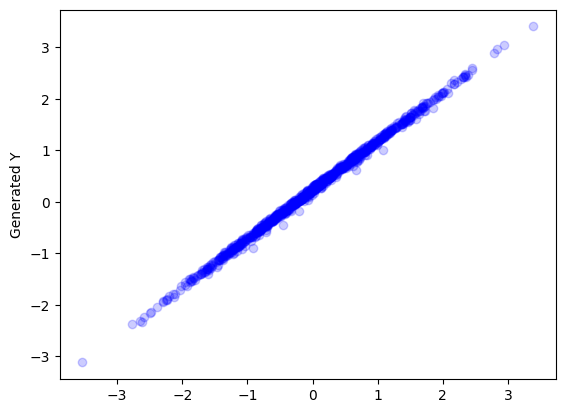

In [8]:
plt.scatter(v, Y, c='blue', alpha=0.2)
plt.ylabel('Generated Y')
plt.show()

# 2. MLE for parameters of covariance model
## 2-1. Log likelihood function

$ -logL(\vec{0}, \Sigma(\theta); \vec{Y}) = \frac{1}{2} ln(|\Sigma(\theta)|) + \frac{1}{2}\vec{Y}^T\Sigma(\theta)^{-1}\vec{Y} $

In [9]:
# check if matrix is psd
def check_pd(Sigma):
  try:
    pd = np.linalg.eig(Sigma)[0].min() 
    if pd > 0:
      return True
  except np.linalg.LinAlgError:
    return False

In [10]:
# check invertible
def check_invertible(matrix):
    try:
        inverse = np.linalg.inv(matrix)
        return True
    except np.linalg.LinAlgError:
        return False

In [11]:
# define log likelihood function
def logLikelihood(param, Y):
    
    p = len(Y)
    sig = Sigma(param,p)
    chol = check_pd(sig)
    inv = check_invertible(sig)
    
    if chol: 
      # choleskey factorization
      log_det_Sigma = 2*np.sum(np.log(np.diag(np.linalg.cholesky(sig))))
    else: 
       # LU factorization
       P, L, U = lu(sig)
       sign_P = np.linalg.det(P)
       log_det_Sigma = np.log(np.abs((-1) ** sign_P * np.prod(np.diag(U))))
       
    
    if inv:
      inv_Sigma = np.linalg.inv(sig)
    else:
      inv_Sigma = np.linalg.pinv(sig) # pseudo inverse

    return 0.5 * Y.T @ inv_Sigma @ Y + 0.5 * log_det_Sigma


## 2-2. MLE

In [12]:
# set the seed
param0 = paramTrue + np.random.normal(0, 1, 1)

# define the optimization problem
problem = {
    'fun': logLikelihood,         # objective function: 
    'x0': param0,            # Initial guess for the parameters
    'args': (Y,),             # Additional arguments for the objective function      
}

result = minimize(**problem)
estimated_params = result.x

In [14]:
print('True paramter: ', paramTrue)
print('Esimated parameter: ', estimated_params)

True paramter:  [1, 0.1]
Esimated parameter:  [1.29004206 0.39827116]
